# DOWNLOAD DATASET

In [ ]:
!curl -L "https://universe.roboflow.com/ds/67eqWETpY5?key=xaYv7CYzJw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0    631      0  0:00:01  0:00:01 --:--:--   631
100 29.5M  100 29.5M    0     0  4644k      0  0:00:06  0:00:06 --:--:-- 6284k
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/20241012-224209_png.rf.45c515e451e28d2efc6312b93f715aec.jpg  
  inflating: test/20241012-224209_png.rf.45c515e451e28d2efc6312b93f715aec.xml  
 extracting: test/20241013-121203_png.rf.ebcc20ab64a6cd427b664a2f2ff7874b.jpg  
  inflating: test/20241013-121203_png.rf.ebcc20ab64a6cd427b664a2f2ff7874b.xml  
 extracting: test/20241013-121423_png.rf.1486a449ed6d86ac59a4aab97a648ec8.jpg  
  inflating: test/20241013-121423_png.rf.1486a449ed6d86ac59a4aab97a648ec8.xml  
 extracting: test/20241013-121514_png.rf.a5d3919fd6c127a3a95e1becf3bfaebd.jpg  
  infl

# TEST IMAGES

In [ ]:
# Script to run custom TFLite model on test images to detect objects
# Source: https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py

# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Define function for inferencing with TFLite model and displaying results

def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

  # Grab filenames of all images in test folder
  images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5

  # Randomly select test images
  images_to_test = random.sample(images, num_test_images)

  # Loop over every image and perform detection
  for image_path in images_to_test:

      # Load image and resize to expected shape [1xHxWx3]
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
      if float_input:
          input_data = (np.float32(input_data) - input_mean) / input_std

      # Perform the actual detection by running the model with the image as input
      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()

      # Retrieve detection results
      boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
      classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
      scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

      detections = []

      # Loop over all detections and draw detection box if confidence is above minimum threshold
      for i in range(len(scores)):
          if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

              # Get bounding box coordinates and draw box
              # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
              ymin = int(max(1,(boxes[i][0] * imH)))
              xmin = int(max(1,(boxes[i][1] * imW)))
              ymax = int(min(imH,(boxes[i][2] * imH)))
              xmax = int(min(imW,(boxes[i][3] * imW)))

              cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # Draw label
              object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
              label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
              labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
              label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
              cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
              cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

              detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])


      # All the results have been drawn on the image, now display the image
      if txt_only == False: # "text_only" controls whether we want to display the image results or just save them in .txt files
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,16))
        plt.imshow(image)
        plt.show()

      # Save detection results in .txt files (for calculating mAP)
      elif txt_only == True:

        # Get filenames and paths
        image_fn = os.path.basename(image_path)
        base_fn, ext = os.path.splitext(image_fn)
        txt_result_fn = base_fn +'.txt'
        txt_savepath = os.path.join(savepath, txt_result_fn)

        # Write results to text file
        # (Using format defined by https://github.com/Cartucho/mAP, which will make it easy to calculate mAP)
        with open(txt_savepath,'w') as f:
            for detection in detections:
                f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

  return

In [14]:
### This creates a a "labelmap.txt" file with a list of classes the object detection model will detect.
%%bash
cat <<EOF >> /content/labelmap.txt
10_C
10_D
10_H
10_S
2_C
2_D
2_H
2_S
3_C
3_D
3_H
3_S
4_C
4_D
4_H
4_S
5_C
5_D
5_H
5_S
6_C
6_D
6_H
6_S
7_C
7_D
7_H
7_S
8_C
8_D
8_H
8_S
9_C
9_D
9_H
9_S
A_C
A_D
A_H
A_S
J_C
J_D
J_H
J_S
K_C
K_D
K_H
K_S
Q_C
Q_D
Q_H
Q_S
EOF

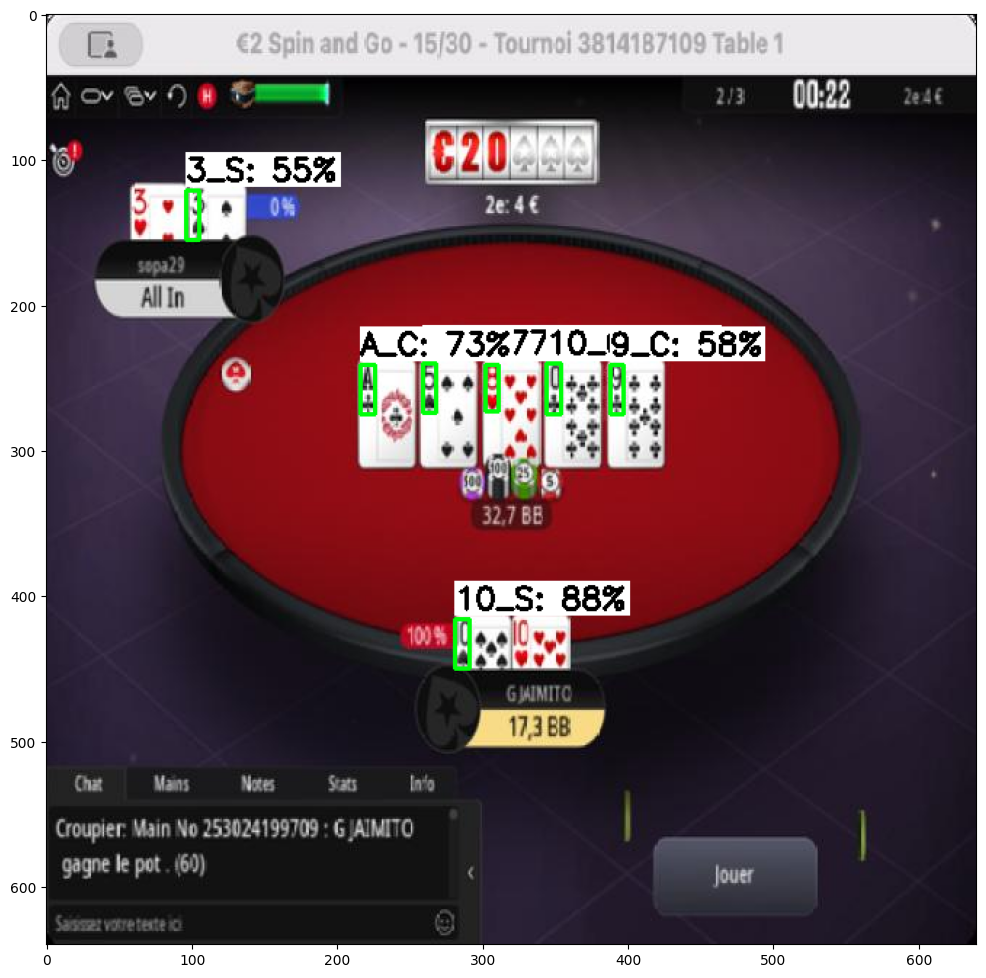

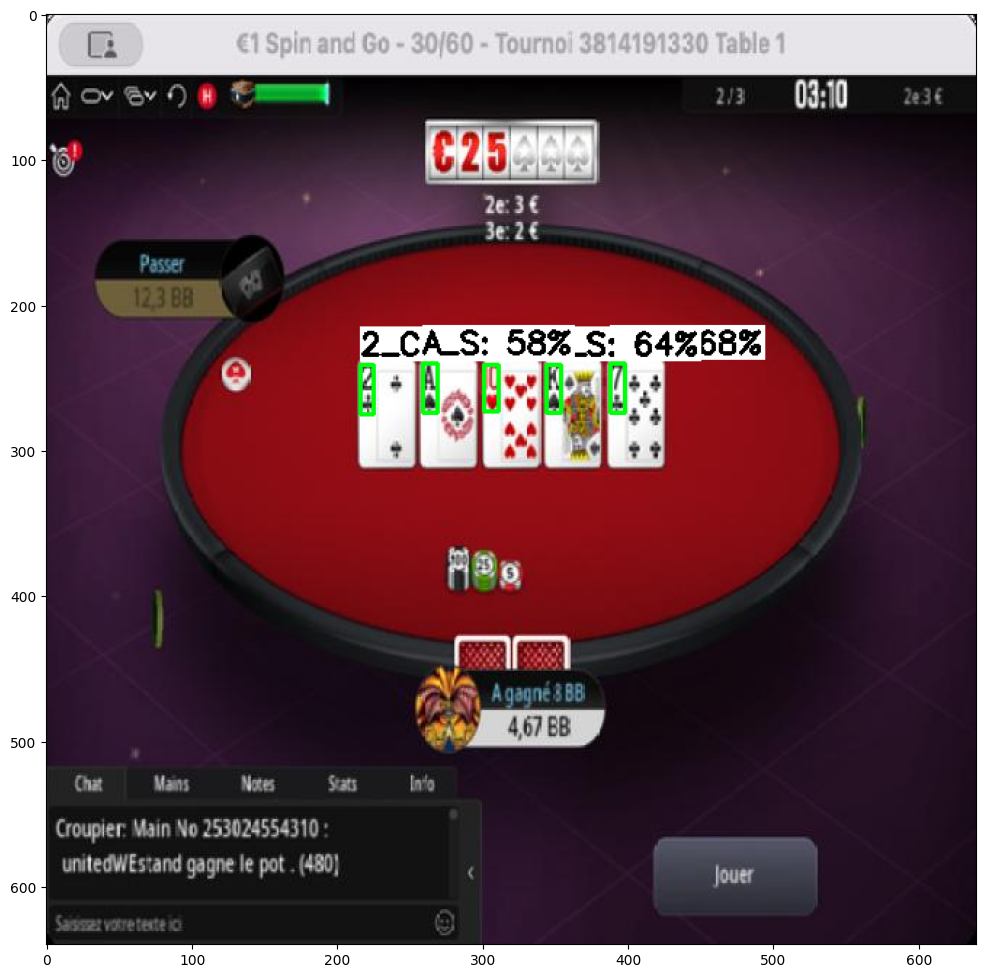

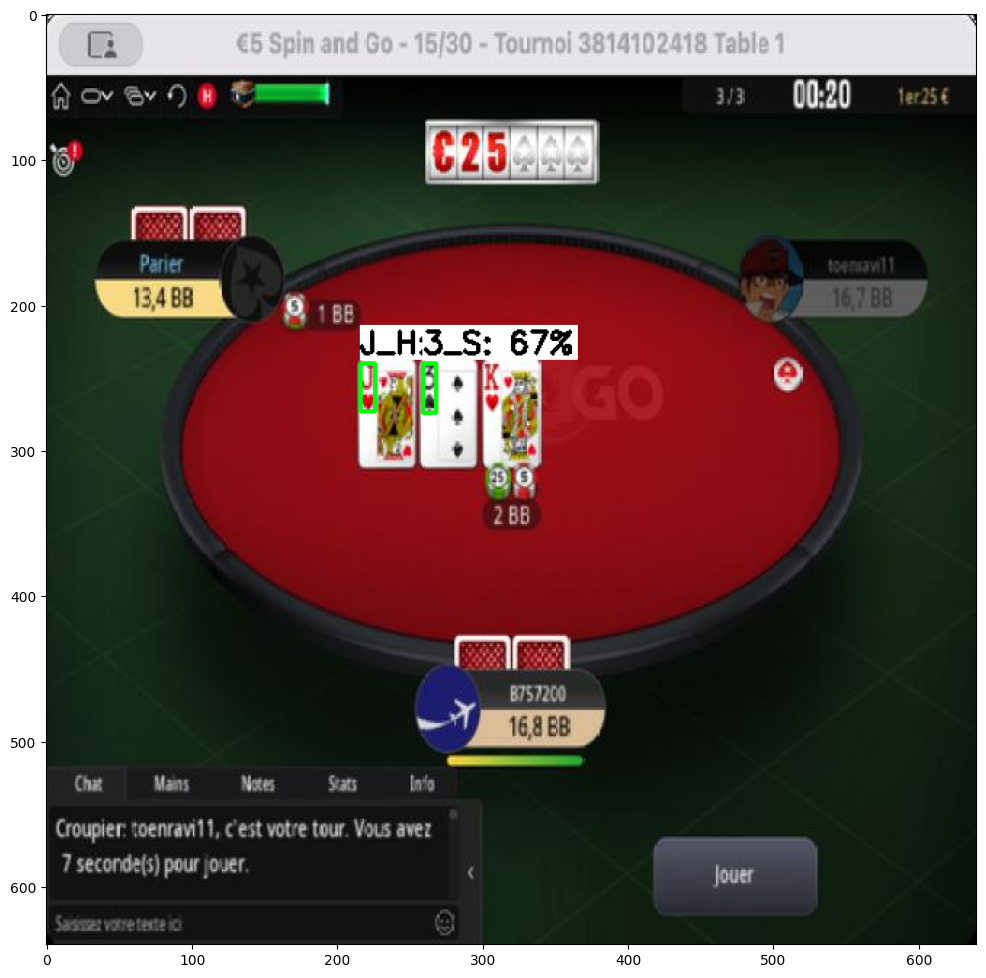

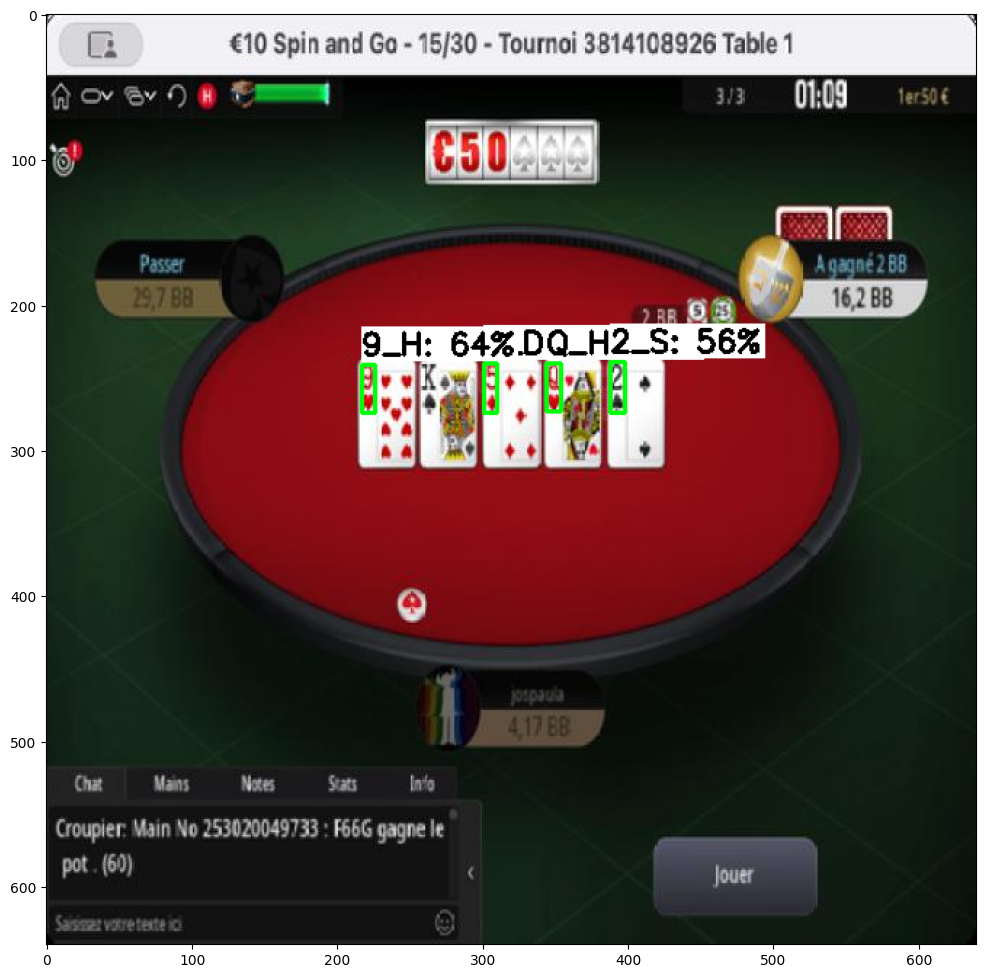

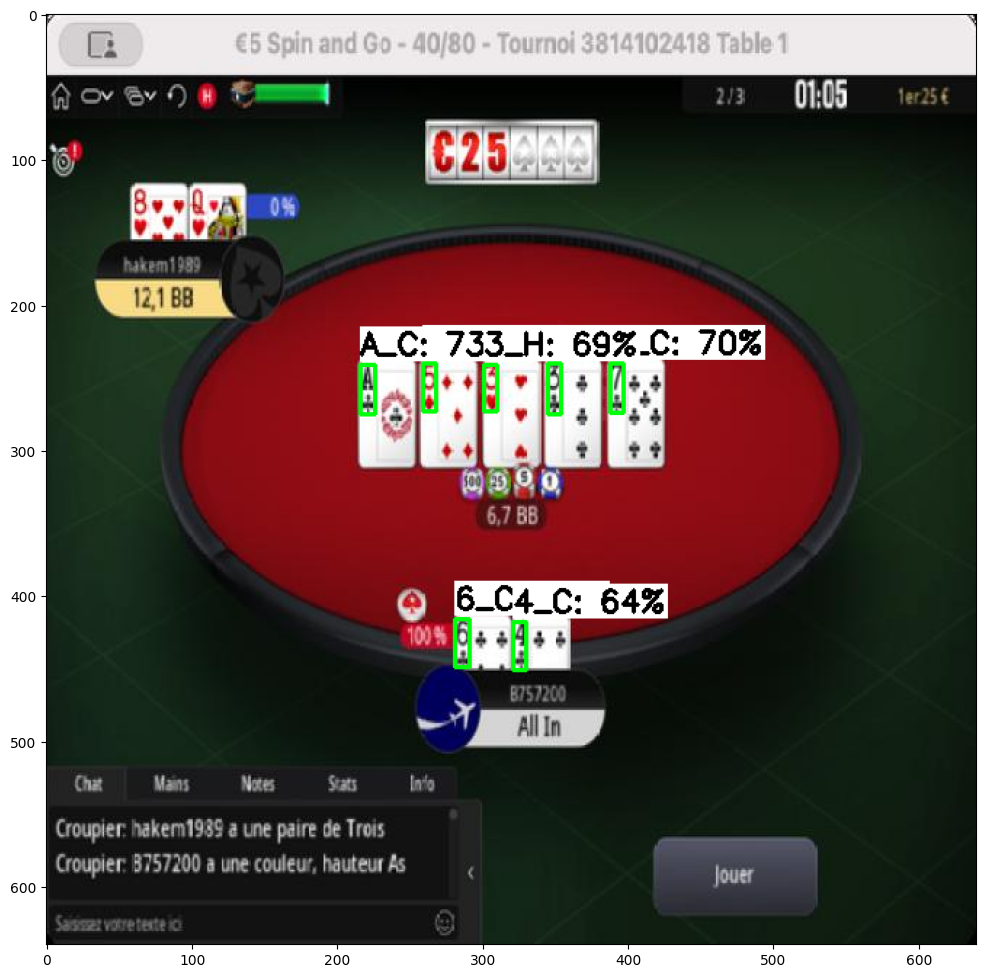

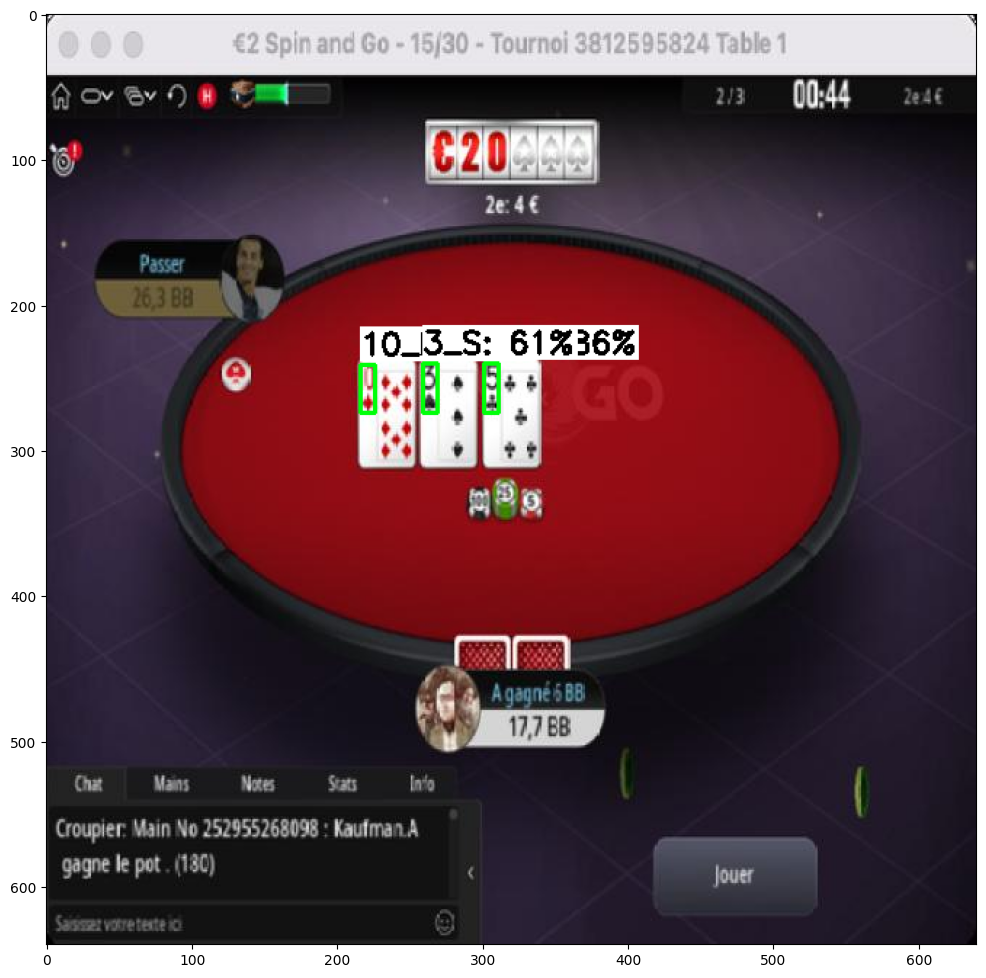

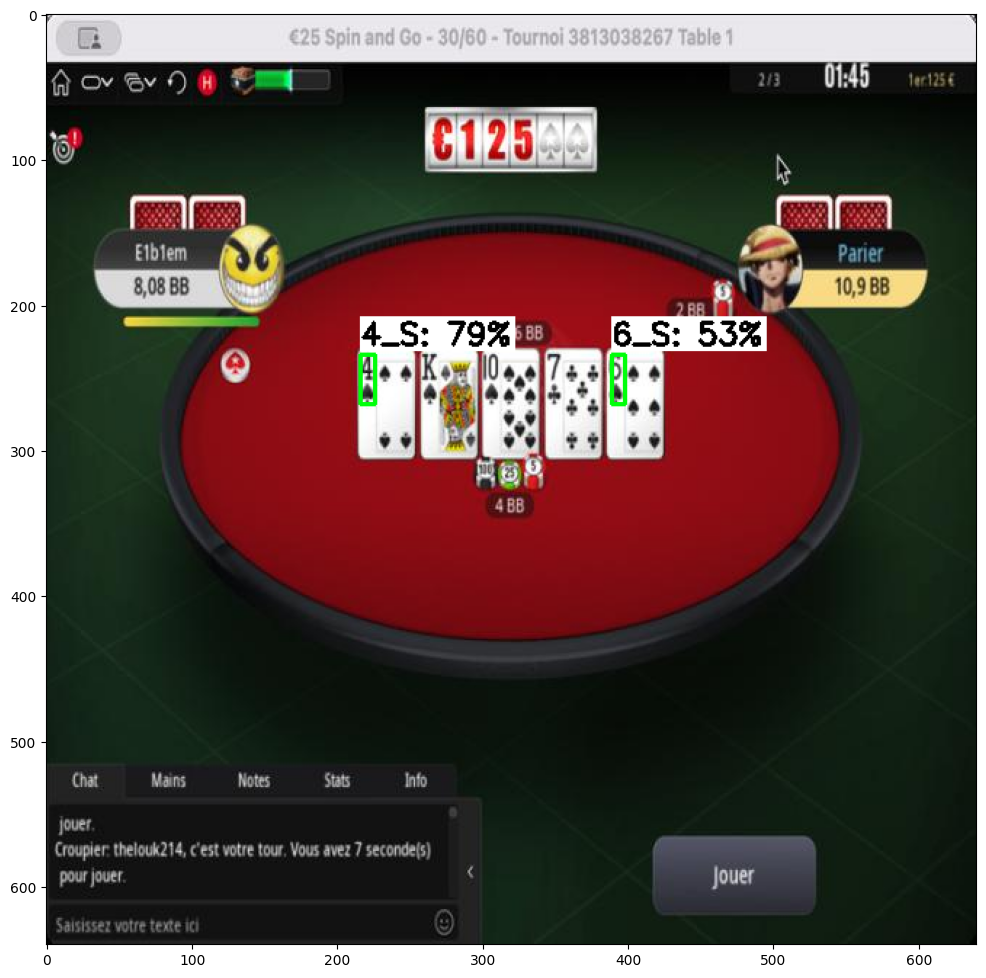

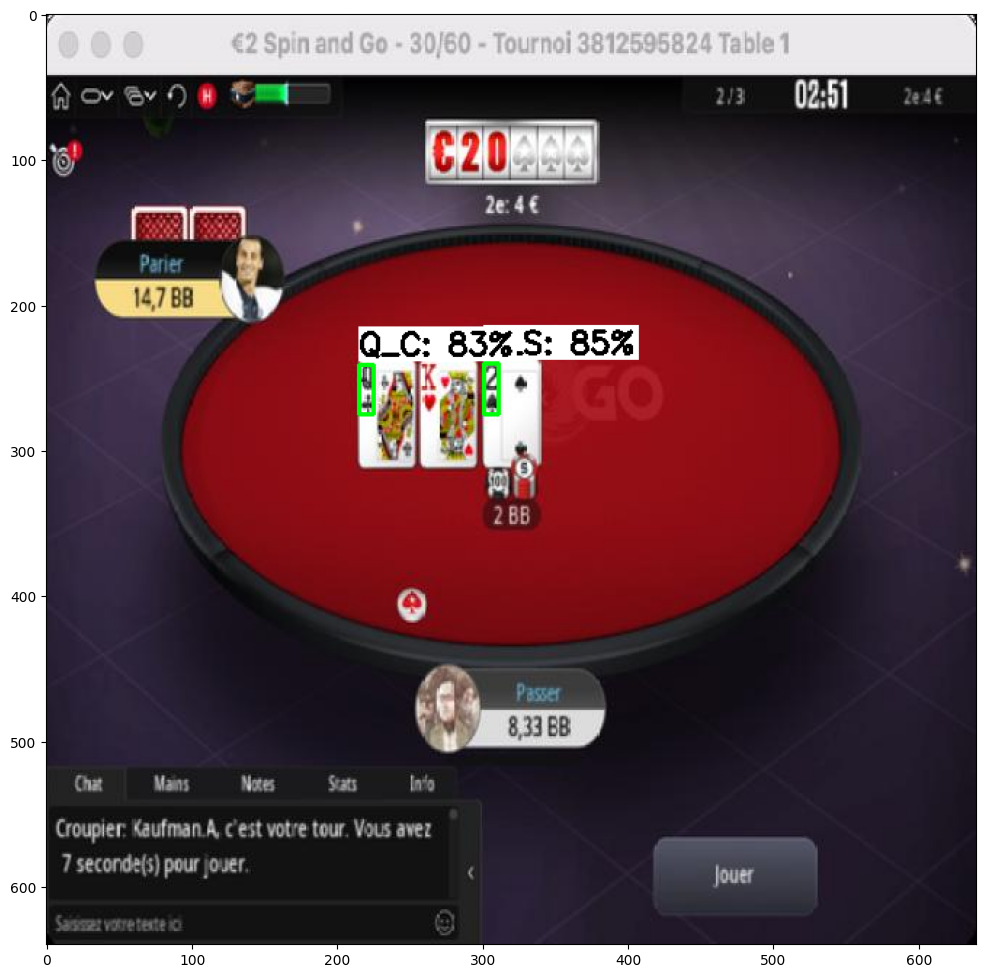

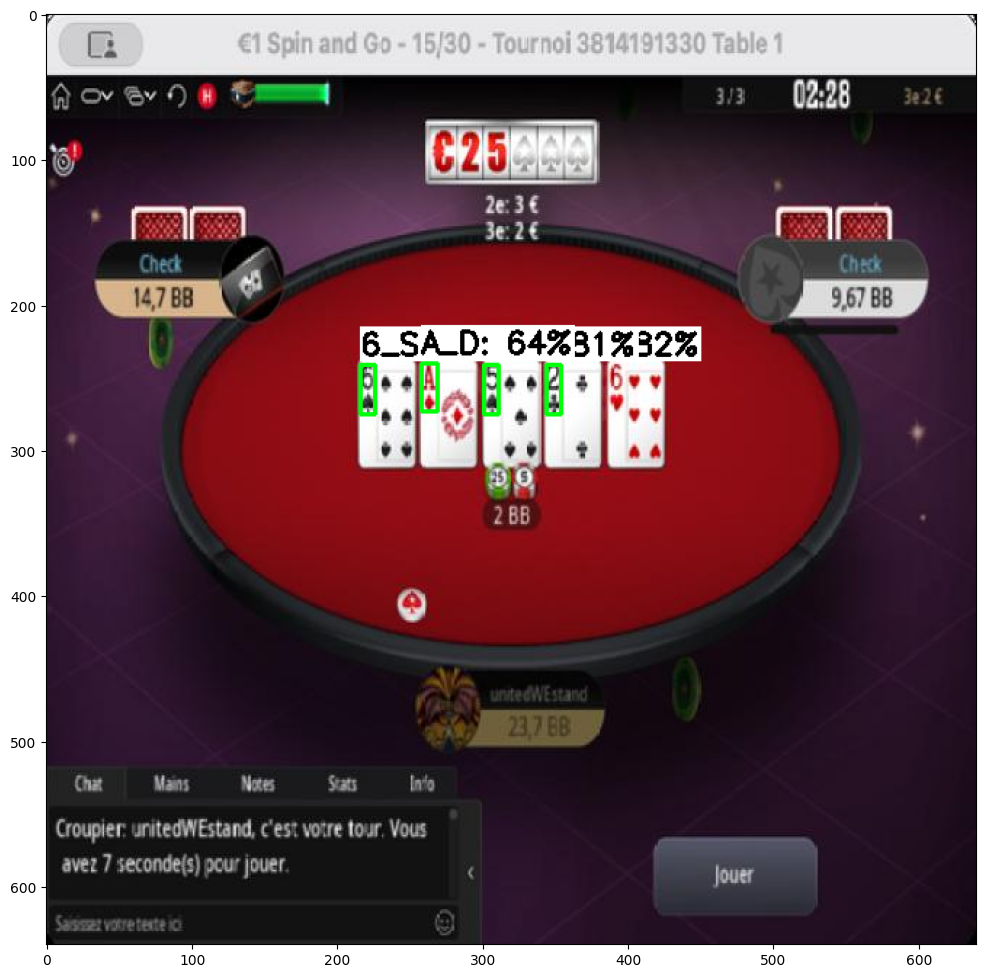

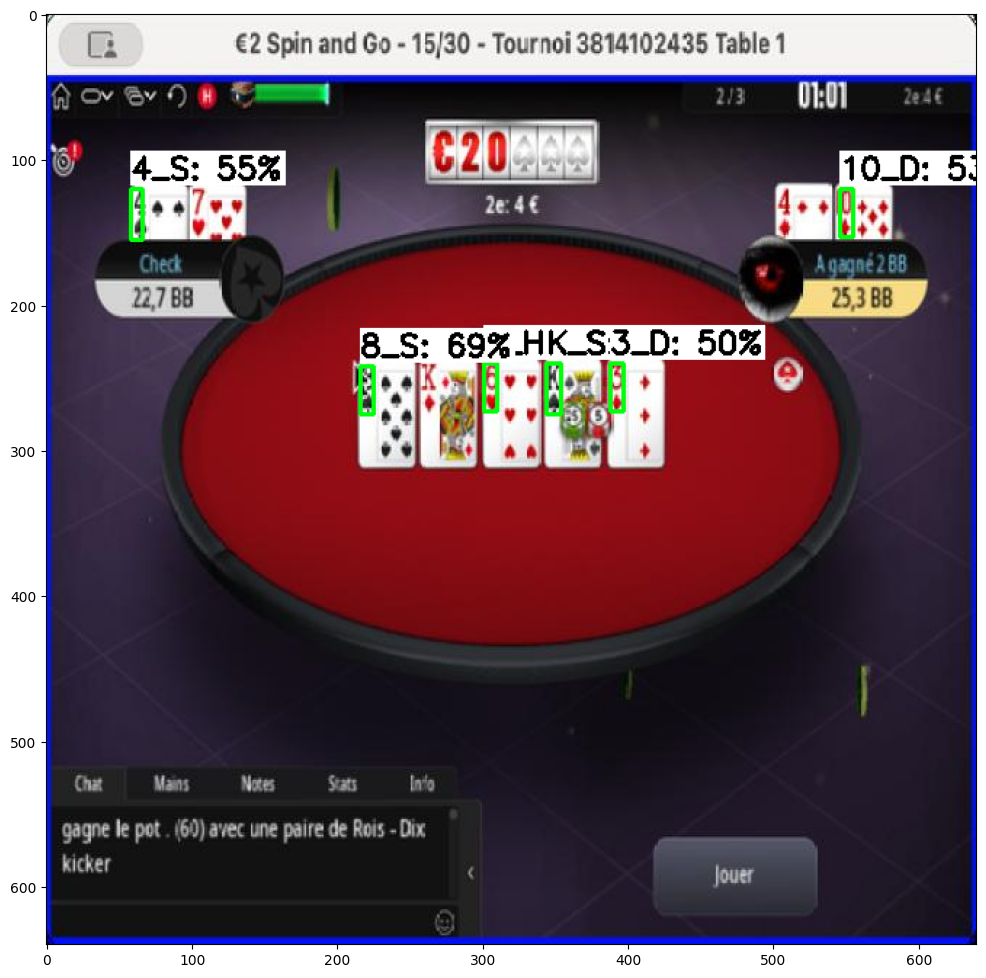

In [ ]:
# Set up variables for running user's model
PATH_TO_IMAGES='/content/test/'   # Path to test images folder
PATH_TO_MODEL='/content/content/custom_model_lite/detect.tflite'   # Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   # Path to labelmap.txt file
min_conf_threshold=0.5   # Confidence threshold (try changing this to 0.01 if you don't see any detection results)
images_to_test = 10   # Number of images to run detection on

# Run inferencing function!
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)

# CALCULATE MAP

In [8]:
%%bash
git clone https://github.com/Cartucho/mAP /content/mAP
cd /content/mAP
rm input/detection-results/*
rm input/ground-truth/*
rm input/images-optional/*
wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/calculate_map_cartucho.py

Cloning into '/content/mAP'...
--2024-10-28 03:13:00--  https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/calculate_map_cartucho.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5397 (5.3K) [text/plain]
Saving to: ‘calculate_map_cartucho.py’

     0K .....                                                 100% 53.7M=0s

2024-10-28 03:13:01 (53.7 MB/s) - ‘calculate_map_cartucho.py’ saved [5397/5397]



In [9]:
!cp /content/test/* /content/mAP/input/images-optional # Copy images and xml files
!mv /content/mAP/input/images-optional/*.xml /content/mAP/input/ground-truth/

In [10]:
# Set up variables for running inference, this time to get detection results saved as .txt files
PATH_TO_IMAGES='/content/test'   # Path to test images folder
PATH_TO_MODEL='/content/content/custom_model_lite/detect.tflite'   # Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   # Path to labelmap.txt file
PATH_TO_RESULTS='/content/mAP/input/detection-results' # Folder to save detection results in
min_conf_threshold=0.1   # Confidence threshold

# Use all the images in the test folder
image_list = glob.glob(PATH_TO_IMAGES + '/*.jpg') + glob.glob(PATH_TO_IMAGES + '/*.JPG') + glob.glob(PATH_TO_IMAGES + '/*.png') + glob.glob(PATH_TO_IMAGES + '/*.bmp')
images_to_test = min(500, len(image_list)) # If there are more than 500 images in the folder, just use 500

# Tell function to just save results and not display images
txt_only = True

# Run inferencing function!
print('Starting inference on %d images...' % images_to_test)
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test, PATH_TO_RESULTS, txt_only)
print('Finished inferencing!')

Starting inference on 71 images...
Finished inferencing!


In [11]:
!python /content/mAP/scripts/extra/convert_gt_xml.py

Conversion completed!


In [12]:
%cd /content/mAP
!python calculate_map_cartucho.py --labels=/content/labelmap.txt

/content/mAP
Calculating mAP at 0.50 IoU threshold...
60.00% = 10_C AP 
85.71% = 10_D AP 
79.76% = 10_H AP 
67.78% = 10_S AP 
98.89% = 2_C AP 
55.56% = 2_D AP 
71.43% = 2_H AP 
100.00% = 2_S AP 
80.00% = 3_C AP 
66.67% = 3_D AP 
85.71% = 3_H AP 
60.42% = 3_S AP 
100.00% = 4_C AP 
83.67% = 4_D AP 
97.62% = 4_H AP 
69.05% = 4_S AP 
98.21% = 5_C AP 
94.64% = 5_D AP 
59.09% = 5_H AP 
86.25% = 5_S AP 
85.86% = 6_C AP 
100.00% = 6_D AP 
90.91% = 6_H AP 
100.00% = 6_S AP 
88.89% = 7_C AP 
100.00% = 7_D AP 
63.64% = 7_H AP 
98.90% = 7_S AP 
71.43% = 8_C AP 
100.00% = 8_D AP 
83.89% = 8_H AP 
92.86% = 8_S AP 
100.00% = 9_C AP 
50.00% = 9_D AP 
75.00% = 9_H AP 
100.00% = 9_S AP 
88.00% = A_C AP 
84.62% = A_D AP 
79.69% = A_H AP 
85.71% = A_S AP 
72.50% = J_C AP 
68.00% = J_D AP 
100.00% = J_H AP 
85.71% = J_S AP 
98.61% = K_C AP 
90.00% = K_D AP 
76.67% = K_H AP 
100.00% = K_S AP 
82.14% = Q_C AP 
66.67% = Q_D AP 
80.00% = Q_H AP 
50.00% = Q_S AP 
mAP = 82.89%
Calculating mAP at 0.55 IoU thresho

SAVE RESULT

In [13]:
from google.colab import files
import os

dir_to_zip = '/content/mAP' #@param {type: "string"}
output_filename = 'midtermsSSD_Evaluation.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yefcs', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>